# Overview

Example task: Try to approximate a random data

- Pyro models: use as normal, with ELBO only. Examples below.

- Pytorch models:

Pytorch does not have sample/distribution functions. Use mean, var as parameters, define a function to generate the distributions, then implement KL_Div and ELBO_loss.

About replacing SVI, according to VAE paper, ELBO could be optimizing directly by SGD, and mean, var parameters could be learned by MCMC - reparameterized trick [1]. Mean, var parameters could be learned also by Inference Network.

- Conclusion:

    - Reparameterized trick has more stable performance, comparing to Inference Network

    - ELBO_loss has good performance, regardless SVI or SGD

    - KL_div has poor performance when training with SGD

    - MSE_loss has good performance on RMSE but poor approximating distributions (has wrong std, sometimes wrong mean)

    - ***Combining MSE + ELBO has good performance on both. This model is implemented only by Pytorch + SGD***

    - ***Using log_var instead std/var make model stable, even KL_div***

[1] Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.
https://arxiv.org/abs/1312.6114

# 1.Preparation

## 1.1 Functions

In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 614kB 5.8MB/s 


In [ ]:
import torch
import pyro
pyro.__version__

'1.5.0'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from pyro.nn import PyroModule, PyroSample, PyroParam
import pyro.distributions as dist

In [ ]:
def visualize(loss_track, param_track, approx):
    plt.plot(range(len(loss_track)), loss_track)
    plt.title('Loss')
    plt.show()

    param_names = param_track[0].keys()
    for param_name in param_names:
        param_value = [param[param_name] for param in param_track]
        plt.plot(range(len(param_value)), param_value)
        plt.title(param_name)
        plt.show()
    plt.hist(approx)
    plt.show()

In [ ]:
def get_muvar(x):
    mu, var = torch.mean(x), torch.var(x)
    return mu, var

def log_norm(x, mu, var):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*var) -(0.5 * (1/var)* (x-mu)**2)

In [ ]:

# see torch.nn.KLDivLoss
class KLDiv_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(KLDiv_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, var_p = get_muvar(target)
        log_p = log_norm(target, mu_p, var_p)
        mu_q, var_q = get_muvar(target)
        log_q = log_norm(input, mu_q, var_q)
        return torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)

class ELBO_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(ELBO_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, var_p = get_muvar(target)
        log_p = log_norm(target, mu_p, var_p)
        mu_q, var_q = get_muvar(target)
        log_q = log_norm(input, mu_q, var_q)
        kl_div = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = log_norm(target, mu_q, var_q)
        if self.reduction == 'mean':
            reconstruct_loss = torch.mean(log_p)
        else:
            reconstruct_loss = torch.sum(log_p)
        elbo = reconstruct_loss - kl_div
        return -elbo

class Combining_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(Combining_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, var_p = get_muvar(target)
        log_p = log_norm(target, mu_p, var_p)
        mu_q, var_q = get_muvar(target)
        log_q = log_norm(input, mu_q, var_q)

        kl_loss = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

        loss = -(reconstruct_loss - kl_loss)
        return loss

## 1.2 Random data for observations

(array([  1.,   5.,  20.,  78., 205., 288., 230., 126.,  35.,  12.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

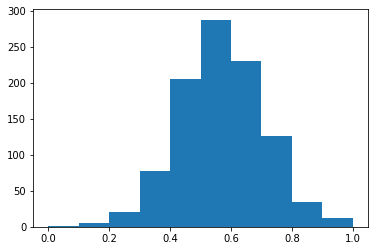

In [ ]:
def scale_minmax(x):
    vmin, vmax = torch.min(x), torch.max(x)
    return (x - vmin)/(vmax-vmin)

arr = scale_minmax(torch.randn(1000))
arr.shape
plt.hist(arr.data.numpy())

# 2.Train by SVI and ELBO

In [ ]:
from pyro.optim import Adam
from pyro.infer import Trace_ELBO, SVI
from pyro.infer.autoguide import AutoDiagonalNormal

def svi_training(model, guide, obs, epochs=100):
    pyro.clear_param_store()

    adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    svi = SVI(model, guide, optimizer, loss=Trace_ELBO(retain_graph=True))

    epochs  = 100
    view_step = epochs/10

    loss_track, param_track = [], []
    for step in range(epochs):
        loss = svi.step(obs)
        loss_track.append(loss)
        params = model.get_param()
        param_track.append(params)
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ("Step %d" % step)
            r = dist.Normal(torch.tensor([params['phi']]), torch.tensor([params['tau']])).sample([1000])
            rmse = np.sqrt(np.mean((r.data.numpy() - arr.data.numpy())**2))
            print ('+ Loss = %.6f, RMSE = %.6f ' % (loss, rmse))
            print ('+ Param: ', params)
            if loss < 0:
                print ('early stopping')
                break
    return loss_track, param_track

### ELBO with Pyro model: ok

In [ ]:
class Demo_SVI(PyroModule):
    def __init__(self):
        super(Demo_SVI, self).__init__()
        self.phi = PyroParam(dist.Uniform(0, 1), event_dim = 1) #mean
        self.tau = PyroParam(dist.Uniform(0, 1), event_dim = 1) #std

    def forward(self, obs):
        with pyro.plate("obs", obs.shape[0]):
            return pyro.sample("x", dist.Normal(loc = self.phi, scale = self.tau), obs = obs)

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return dist.Normal(loc=self.phi, scale=self.tau).sample([n_sample])

def guide(obs):
    pass

In [ ]:
model =  Demo_SVI()
# guide = AutoDiagonalNormal(model)
loss_track, param_track = svi_training(model, guide, arr)

Step 0
+ Loss = 884.198730, RMSE = 0.948115 
+ Param:  {'phi': 0.34720683097839355, 'tau': 0.9243946075439453}
Step 9
+ Loss = 827.471008, RMSE = 0.918225 
+ Param:  {'phi': 0.3919597864151001, 'tau': 0.8792827129364014}
Step 19
+ Loss = 762.306763, RMSE = 0.855536 
+ Param:  {'phi': 0.44006481766700745, 'tau': 0.828569769859314}
Step 29
+ Loss = 694.540466, RMSE = 0.818785 
+ Param:  {'phi': 0.4842223823070526, 'tau': 0.7767939567565918}
Step 39
+ Loss = 623.449768, RMSE = 0.728396 
+ Param:  {'phi': 0.5213834047317505, 'tau': 0.7236453890800476}
Step 49
+ Loss = 547.602966, RMSE = 0.692972 
+ Param:  {'phi': 0.5481489300727844, 'tau': 0.6689330339431763}
Step 59
+ Loss = 464.664429, RMSE = 0.620951 
+ Param:  {'phi': 0.5621389150619507, 'tau': 0.6125040650367737}
Step 69
+ Loss = 371.768799, RMSE = 0.576854 
+ Param:  {'phi': 0.5642272233963013, 'tau': 0.5541583895683289}
Step 79
+ Loss = 266.055176, RMSE = 0.509338 
+ Param:  {'phi': 0.5596254467964172, 'tau': 0.493607759475708}
Ste

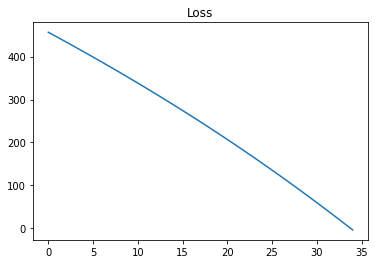

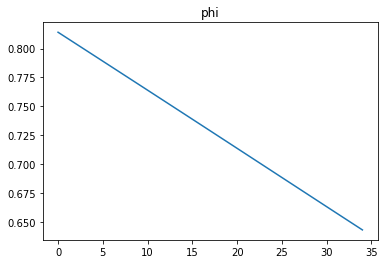

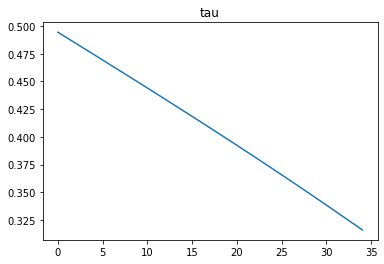

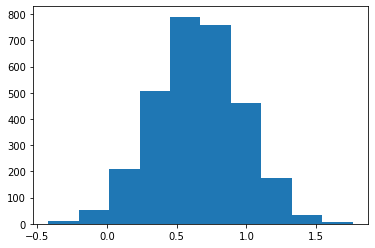

In [ ]:
visualize(loss_track, param_track, model.get_approx())

### ELBO with Pytorch model - MCMC reparameterized trick: ok

In [ ]:
class Demo_SVI_MCTrick(PyroModule):
    def __init__(self):
        super(Demo_SVI_MCTrick, self).__init__()
        self.dim = 1000
        self.phi = torch.nn.Parameter(torch.randn(1), requires_grad=True) #mean, replace PyroParam
        self.tau = torch.nn.Parameter(torch.randn(1), requires_grad=True) #std, replace PyroParam
        self.phi.data.fill_(1.0)
        self.tau.data.fill_(1.0)

    def forward(self, obs):
        with pyro.plate("obs", obs.shape[0]):
            return pyro.sample("x", dist.Normal(loc = self.phi, scale = self.tau), obs = obs)

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=1000):
        return dist.Normal(loc = self.phi, scale = self.tau).sample([n_sample])

def guide(obs):
    pass

In [ ]:
model =  Demo_SVI_MCTrick()
# guide = AutoDiagonalNormal(model)
loss_track, param_track = svi_training(model, guide, arr)

Step 0
+ Loss = 1047.005615, RMSE = 1.088273 
+ Param:  {'phi': 0.9950000047683716, 'tau': 0.9950000047683716}
Step 9
+ Loss = 990.773865, RMSE = 1.058846 
+ Param:  {'phi': 0.9500109553337097, 'tau': 0.9498749375343323}
Step 19
+ Loss = 924.900391, RMSE = 1.007243 
+ Param:  {'phi': 0.9001099467277527, 'tau': 0.8990670442581177}
Step 29
+ Loss = 854.666016, RMSE = 0.951820 
+ Param:  {'phi': 0.850449800491333, 'tau': 0.8470147252082825}
Step 39
+ Loss = 779.191162, RMSE = 0.836615 
+ Param:  {'phi': 0.8012503385543823, 'tau': 0.7932900786399841}
Step 49
+ Loss = 697.514709, RMSE = 0.775855 
+ Param:  {'phi': 0.7528098225593567, 'tau': 0.7375823259353638}
Step 59
+ Loss = 608.548462, RMSE = 0.716073 
+ Param:  {'phi': 0.70554518699646, 'tau': 0.6796540021896362}
Step 69
+ Loss = 511.016144, RMSE = 0.663199 
+ Param:  {'phi': 0.6600691676139832, 'tau': 0.619303286075592}
Step 79
+ Loss = 403.384949, RMSE = 0.585548 
+ Param:  {'phi': 0.6173190474510193, 'tau': 0.5563453435897827}
Step 8

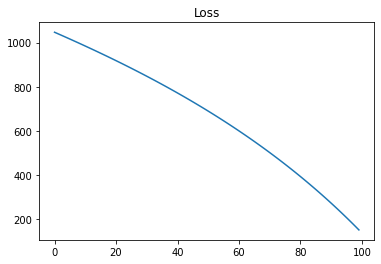

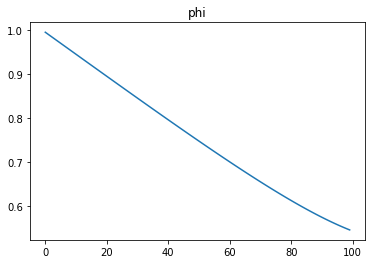

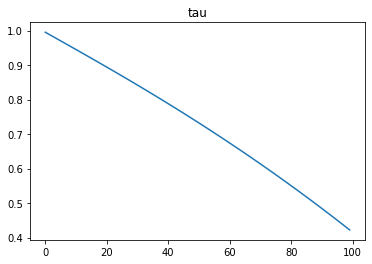

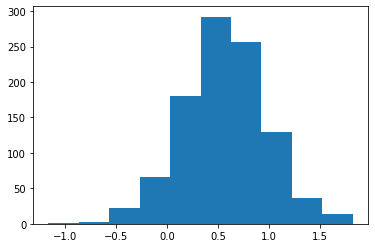

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy())

### ELBO with Pytorch model - Inference network

In [ ]:
class Demo_SVI_InferNet(PyroModule):
    def __init__(self, dim = 1000):
        super(Demo_SVI_InferNet, self).__init__()
        self.dim = 1000
        self.mean_fc = torch.nn.Linear(1, 1)
        self.var_fc = torch.nn.Linear(1, 1)
        self.phi, self.tau = None, None #mean, std

    def forward(self, obs):
        self.phi = torch.mean(self.mean_fc(obs))
        self.tau = torch.mean(self.var_fc(obs))
        with pyro.plate("obs", len(arr)):
            return pyro.sample("x", dist.Normal(loc = self.phi, scale = self.tau), obs = arr)

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=1000):
        return dist.Normal(loc = self.phi, scale = self.tau).sample([n_sample])

def guide(obs):
    pass

In [ ]:
model =  Demo_SVI_InferNet()
# guide = AutoDiagonalNormal(model)
loss_track, param_track = svi_training(model, guide, arr.reshape([1000, 1]))

/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWar

Step 0
+ Loss = nan, RMSE = 1.370562 
+ Param:  {'phi': -0.8359481692314148, 'tau': -0.06029638275504112}
Step 9
+ Loss = nan, RMSE = 1.306908 
+ Param:  {'phi': -0.7732464075088501, 'tau': -0.11885447800159454}
Step 19
+ Loss = nan, RMSE = 1.263433 
+ Param:  {'phi': -0.7211165428161621, 'tau': -0.15842409431934357}
Step 29
+ Loss = nan, RMSE = 1.223603 
+ Param:  {'phi': -0.6824823021888733, 'tau': -0.18178904056549072}
Step 39
+ Loss = nan, RMSE = 1.198132 
+ Param:  {'phi': -0.6517953872680664, 'tau': -0.19667834043502808}
Step 49
+ Loss = nan, RMSE = 1.175714 
+ Param:  {'phi': -0.6254510879516602, 'tau': -0.20724228024482727}
Step 59
+ Loss = nan, RMSE = 1.152580 
+ Param:  {'phi': -0.6014233827590942, 'tau': -0.2155732959508896}
Step 69
+ Loss = nan, RMSE = 1.153572 
+ Param:  {'phi': -0.5786768198013306, 'tau': -0.22267942130565643}
Step 79
+ Loss = nan, RMSE = 1.102351 
+ Param:  {'phi': -0.5567167401313782, 'tau': -0.2290349155664444}
Step 89
+ Loss = nan, RMSE = 1.089549 
+ 

/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWar

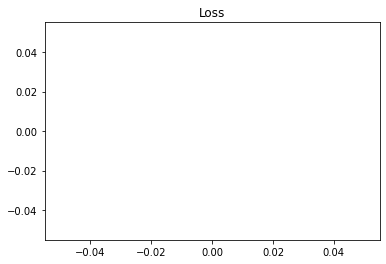

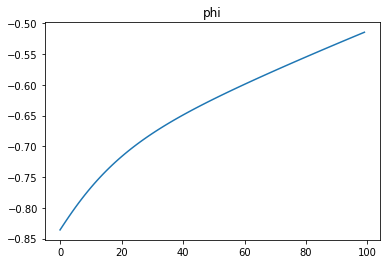

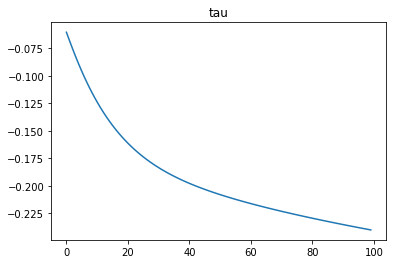

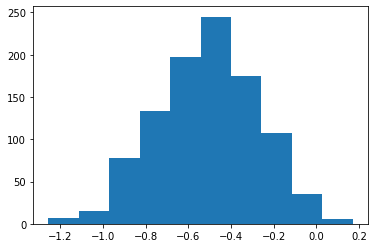

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy())

# 3.Train by SGD

In [ ]:
def sgd_training(model, loss_fn, obs, epochs=500):
    pyro.clear_param_store()
    # loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)

    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        y = model().squeeze(-1) #model.forward(), squeeze ~ reshape(,-1)
        loss = loss_fn(y, obs)
        loss_track.append(loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ("Epoch %d: " % step)
            r = model.get_approx()
            rmse = np.sqrt(np.mean((r.data.numpy() - obs.data.numpy())**2))
            print ('+ Loss = %.6f, RMSE = %.6f ' % (loss, rmse))
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

## 3.1 Pyro models

In [ ]:
class Demo_SGD_Pyro(PyroModule): #similar to Demo_SVI, but adjust for SGD calling
    def __init__(self, dim):
        super(Demo_SGD_Pyro, self).__init__()
        self.dim = dim
        self.phi = PyroParam(dist.Normal(0, 1), event_dim = 1) #mean
        self.tau = PyroParam(dist.Normal(0, 1), event_dim = 1) #std
        self.x = PyroSample(dist.Normal(loc=1.0, scale=1.0).expand([self.dim]).to_event(1))
        #init phi=1.0, tau=1.0. Different init values could cause unconvergence.

    def forward(self):
        self.x = PyroSample(dist.Normal(loc=self.phi, scale=self.tau).expand([self.dim]).to_event(1))
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

### MSE: ok

Epoch 0: 
+ Loss = 4.079412, RMSE = 2.021391 
+ Param:  {'phi': -1.4469375610351562, 'tau': -0.2722809612751007}
Epoch 49: 
+ Loss = 2.359743, RMSE = 1.536434 
+ Param:  {'phi': -0.9727091193199158, 'tau': 0.017040785402059555}
Epoch 99: 
+ Loss = 1.252419, RMSE = 1.119281 
+ Param:  {'phi': -0.5529007315635681, 'tau': -0.007473399862647057}
Epoch 149: 
+ Loss = 0.609904, RMSE = 0.781130 
+ Param:  {'phi': -0.2107851803302765, 'tau': -0.006639627739787102}
Epoch 199: 
+ Loss = 0.274270, RMSE = 0.523788 
+ Param:  {'phi': 0.053128551691770554, 'tau': 0.003216754412278533}
Epoch 249: 
+ Loss = 0.118049, RMSE = 0.343492 
+ Param:  {'phi': 0.2444760799407959, 'tau': 0.0013387453509494662}
Epoch 299: 
+ Loss = 0.053728, RMSE = 0.231837 
+ Param:  {'phi': 0.37422868609428406, 'tau': 0.001055574626661837}
Epoch 349: 
+ Loss = 0.030439, RMSE = 0.174471 
+ Param:  {'phi': 0.45633235573768616, 'tau': -0.0024189536925405264}
Epoch 399: 
+ Loss = 0.023057, RMSE = 0.151873 
+ Param:  {'phi': 0.5048

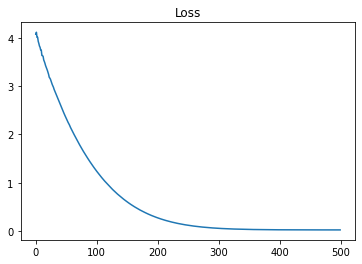

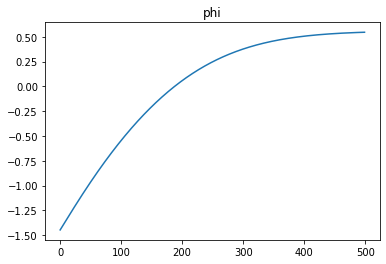

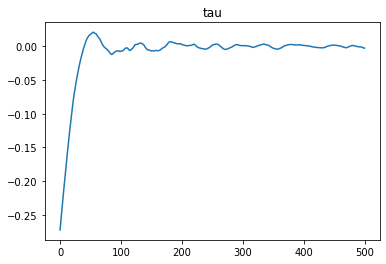

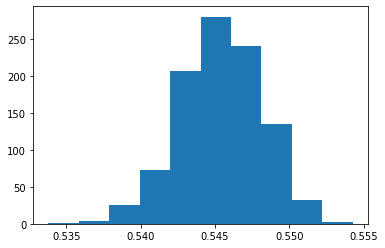

In [ ]:
model = Demo_SGD_Pyro(1000)
loss_fn = torch.nn.MSELoss(reduction='mean')
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

(array([  2.,   4.,  34.,  79., 180., 252., 234., 145.,  58.,  12.]),
 array([0.5351179 , 0.53689224, 0.5386665 , 0.5404408 , 0.54221505,
        0.54398936, 0.5457637 , 0.5475379 , 0.54931223, 0.5510865 ,
        0.5528608 ], dtype=float32),
 <a list of 10 Patch objects>)

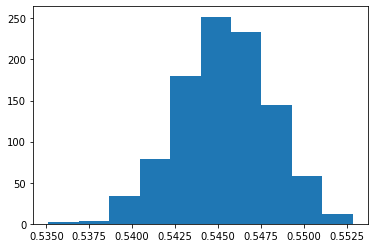

In [ ]:
s1 =  model.get_approx().data.numpy()
plt.hist(s1)

### KL

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 45426.902344, RMSE = 1.229168 
+ Param:  {'phi': 0.66013103723526, 'tau': 1.2115474939346313}
Epoch 49: 
+ Loss = 15348.366211, RMSE = 0.771979 
+ Param:  {'phi': 0.52176433801651, 'tau': 0.751331627368927}
Epoch 99: 
+ Loss = 4110.150879, RMSE = 0.437570 
+ Param:  {'phi': 0.5215617418289185, 'tau': 0.39676132798194885}
Epoch 149: 
+ Loss = 523.062439, RMSE = 0.245939 
+ Param:  {'phi': 0.5250059962272644, 'tau': 0.17599715292453766}
Epoch 170: 
+ Loss = -11.177055, RMSE = 0.204530 
+ Param:  {'phi': 0.5205028057098389, 'tau': 0.11820589005947113}
----Early stopping----


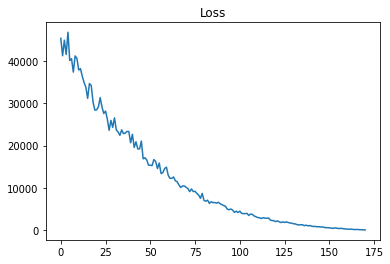

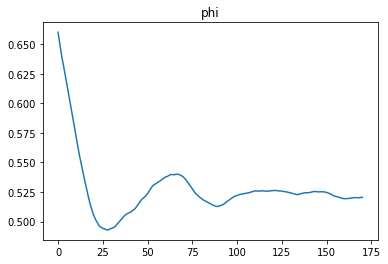

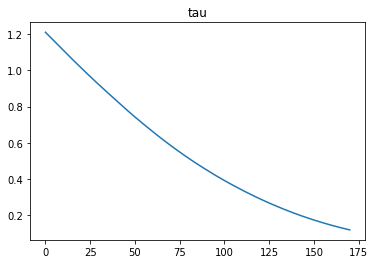

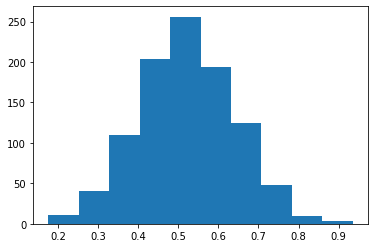

In [ ]:
del model
model = Demo_SGD_Pyro(1000)
loss_fn = KLDiv_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 97533.851562, RMSE = 1.801945 
+ Param:  {'phi': -1.2693325281143188, 'tau': -0.12927265465259552}
Epoch 49: 
+ Loss = 52583.074219, RMSE = 1.330125 
+ Param:  {'phi': -0.7971225380897522, 'tau': -0.015571010299026966}
Epoch 99: 
+ Loss = 24798.982422, RMSE = 0.925132 
+ Param:  {'phi': -0.3885079324245453, 'tau': -0.004853344522416592}
Epoch 149: 
+ Loss = 10174.595703, RMSE = 0.613625 
+ Param:  {'phi': -0.06837932020425797, 'tau': -0.00712514016777277}
Epoch 199: 
+ Loss = 3460.545166, RMSE = 0.394395 
+ Param:  {'phi': 0.16475912928581238, 'tau': -0.007840246893465519}
Epoch 249: 
+ Loss = 803.605774, RMSE = 0.260899 
+ Param:  {'phi': 0.32118135690689087, 'tau': 0.0001691009965725243}
Epoch 291: 
+ Loss = -8.888936, RMSE = 0.203370 
+ Param:  {'phi': 0.40528085827827454, 'tau': -0.0005750783602707088}
----Early stopping----


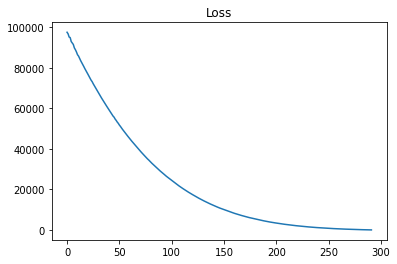

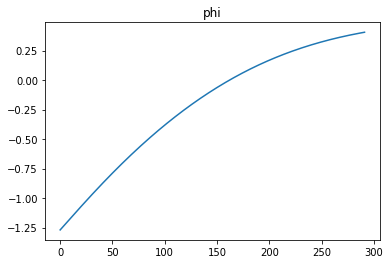

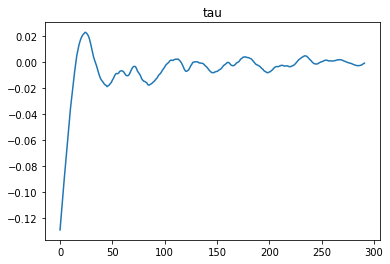

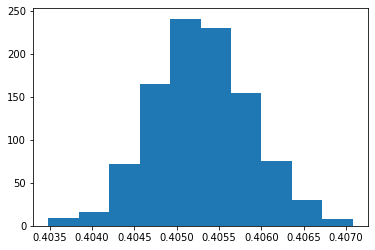

In [ ]:
model = Demo_SGD_Pyro(1000)
loss_fn = KLDiv_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

#### Use built-in KL-div function

In [ ]:
def sgd_training_getlognorm(model, loss_fn, obs, epochs=500):
    pyro.clear_param_store()
    # loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)

    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        y = model().squeeze(-1) #model.forward(), squeeze ~ reshape(,-1)
        loss = loss_fn(log_norm(y, torch.mean(y), torch.var(y)), log_norm(obs, torch.mean(obs), torch.var(obs)))
        loss_track.append(loss)
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ("Epoch %d: " % step)
            r = model.get_approx()
            rmse = np.sqrt(np.mean((r.data.numpy() - obs.data.numpy())**2))
            print ('+ Loss = %.6f, RMSE = %.6f ' % (loss, rmse))
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

Epoch 0: 
+ Loss = 1797.087769, RMSE = 1.179007 
+ Param:  {'phi': -0.5815134644508362, 'tau': -0.3896773159503937}
Epoch 26: 
+ Loss = -265.272491, RMSE = 1.155131 
+ Param:  {'phi': -0.6142125725746155, 'tau': -0.11419863998889923}
----Early stopping----


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


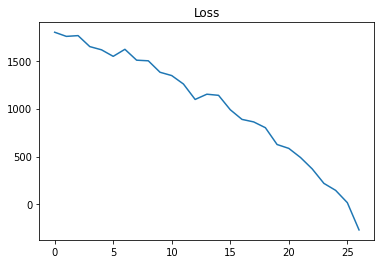

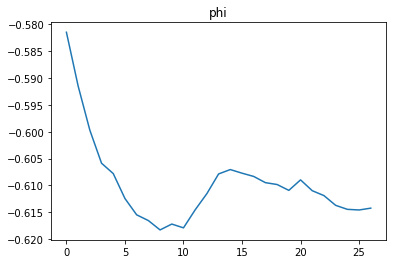

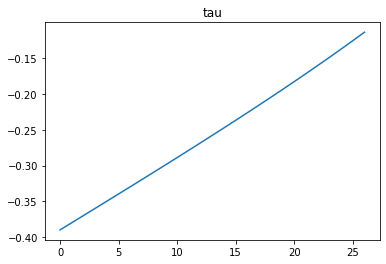

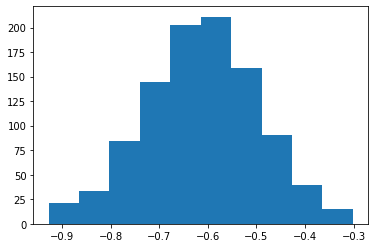

In [ ]:
# del model
model = Demo_SGD_Pyro(1000)
loss_fn = torch.nn.KLDivLoss(reduction='mean', size_average=False, log_target= True)
loss_track, param_track = sgd_training_getlognorm(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

### ELBO: ok

Epoch 0: 
+ Loss = 3489.950195, RMSE = 0.330442 
+ Param:  {'phi': 0.4770265817642212, 'tau': 0.2967739999294281}
Epoch 16: 
+ Loss = -15.387756, RMSE = 0.212002 
+ Param:  {'phi': 0.5864971280097961, 'tau': 0.14196740090847015}
----Early stopping----


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


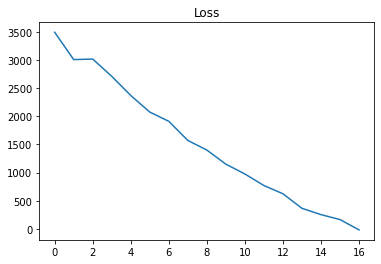

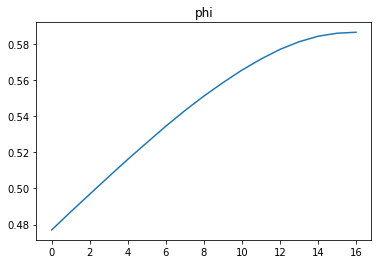

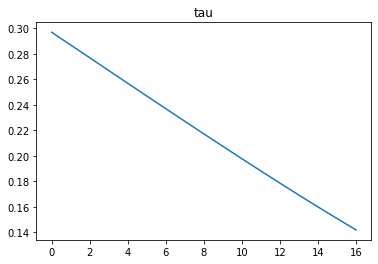

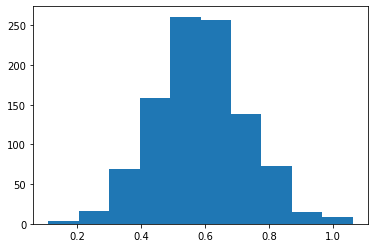

In [ ]:
model = Demo_SGD_Pyro(1000)
loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

(array([  3.,  21.,  76., 214., 278., 231., 118.,  44.,  14.,   1.]),
 array([0.09541076, 0.1977205 , 0.30003023, 0.40233997, 0.5046497 ,
        0.60695946, 0.70926917, 0.81157887, 0.91388863, 1.0161984 ,
        1.1185081 ], dtype=float32),
 <a list of 10 Patch objects>)

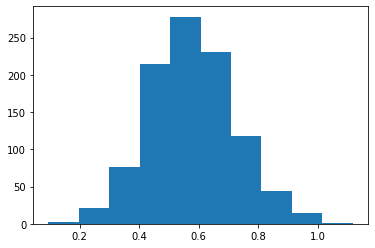

In [ ]:
s2 =  model.get_approx().data.numpy()
plt.hist(s2)

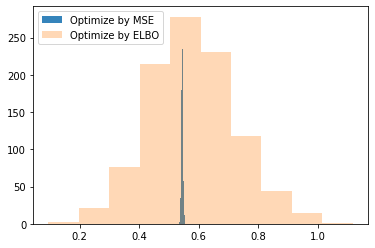

In [ ]:
plt.hist(s1, alpha = 0.9, label='Optimize by MSE')
plt.hist(s2, alpha = 0.3, label='Optimize by ELBO')
plt.legend(loc='upper left')

plt.show()

## 3.2 Pytorch models - MCMC reparameterized trick


In [ ]:
class Demo_SGD_MCTrick(torch.nn.Module):
    #similar to Demo_SGD_Pyro, but change forward function to fit with Pytorch calling by MCMC sampling for x
    def __init__(self, dim = 1000):
        super(Demo_SGD_MCTrick, self).__init__()
        self.dim = dim
        self.phi = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.tau = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.phi.data.fill_(1)
        self.tau.data.fill_(1)
        self.x = self.generate()

    def generate(self):
        eps = scale_minmax(torch.randn(self.dim))-0.5
        x_hat = self.phi + self.tau * 2 * eps
        return x_hat

    def forward(self):
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

### MSE: ok

Epoch 0: 
+ Loss = 0.275605, RMSE = 0.524981 
+ Param:  {'phi': 1.0, 'tau': 0.8224405646324158}
Epoch 49: 
+ Loss = 0.038638, RMSE = 0.196565 
+ Param:  {'phi': 0.6104989051818848, 'tau': 0.39226603507995605}
Epoch 99: 
+ Loss = 0.021489, RMSE = 0.146591 
+ Param:  {'phi': 0.5570366382598877, 'tau': 0.12921608984470367}
Epoch 149: 
+ Loss = 0.020505, RMSE = 0.143195 
+ Param:  {'phi': 0.5570764541625977, 'tau': 0.026114733889698982}
Epoch 199: 
+ Loss = 0.020339, RMSE = 0.142615 
+ Param:  {'phi': 0.557125449180603, 'tau': 0.0035990532487630844}
Epoch 249: 
+ Loss = 0.020331, RMSE = 0.142586 
+ Param:  {'phi': 0.5570040345191956, 'tau': 0.0016159852966666222}
Epoch 299: 
+ Loss = 0.020322, RMSE = 0.142554 
+ Param:  {'phi': 0.5570656657218933, 'tau': -0.0034567860420793295}
Epoch 349: 
+ Loss = 0.020322, RMSE = 0.142557 
+ Param:  {'phi': 0.5568847060203552, 'tau': -0.004736634436994791}
Epoch 399: 
+ Loss = 0.020337, RMSE = 0.142608 
+ Param:  {'phi': 0.5570318102836609, 'tau': -0.001

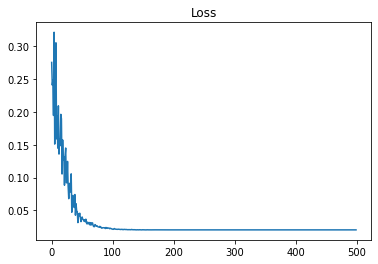

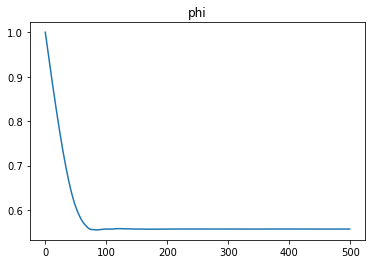

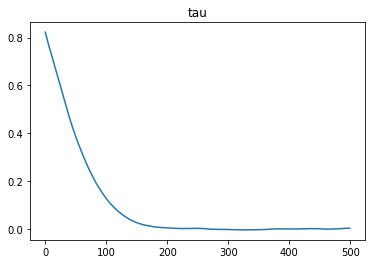

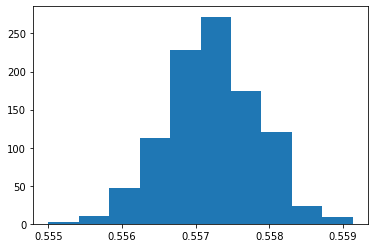

In [ ]:
model = Demo_SGD_MCTrick(1000)
loss_fn = torch.nn.MSELoss(reduction='mean')
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

(array([  2.,  10.,  47., 113., 228., 272., 174., 121.,  24.,   9.]),
 array([0.5550014 , 0.5554143 , 0.55582726, 0.55624026, 0.5566532 ,
        0.55706614, 0.5574791 , 0.557892  , 0.558305  , 0.55871797,
        0.5591309 ], dtype=float32),
 <a list of 10 Patch objects>)

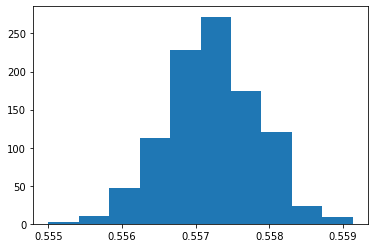

In [ ]:
sa =  model.get_approx().data.numpy()
plt.hist(sa)

### KL

Epoch 0: 
+ Loss = 1010.990845, RMSE = 0.488588 
+ Param:  {'phi': 1.0, 'tau': 0.699992835521698}
Epoch 26: 
+ Loss = -3.027018, RMSE = 0.519810 
+ Param:  {'phi': 1.0252220630645752, 'tau': 0.4320778250694275}
----Early stopping----


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


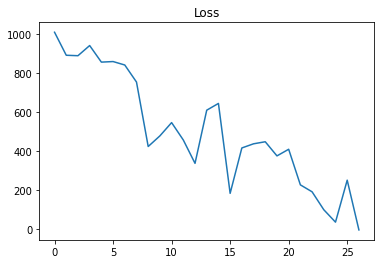

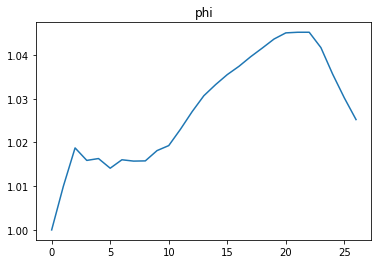

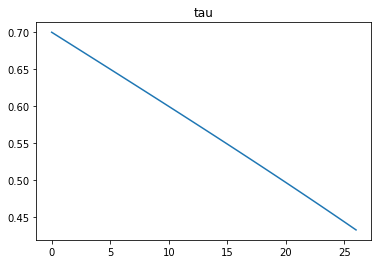

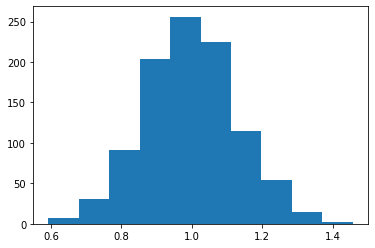

In [ ]:
del model
model = Demo_SGD_MCTrick(1000)
loss_fn = torch.nn.KLDivLoss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training_getlognorm(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

### ELBO: ok

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 8424.685547, RMSE = 0.461874 
+ Param:  {'phi': 1.0, 'tau': 0.12582078576087952}
Epoch 34: 
+ Loss = -71.609863, RMSE = 0.199318 
+ Param:  {'phi': 0.6947534680366516, 'tau': 0.025625910609960556}
----Early stopping----


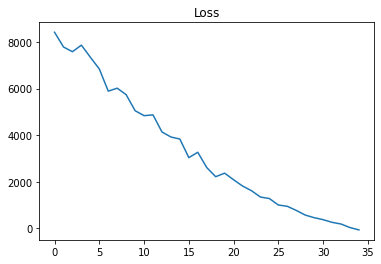

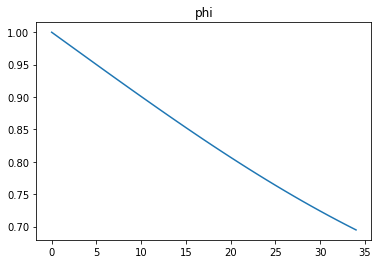

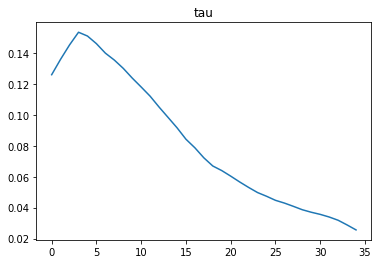

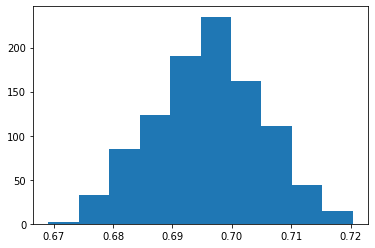

In [ ]:
model = Demo_SGD_MCTrick(1000)
loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 15525.758789, RMSE = 0.604937 
+ Param:  {'phi': 1.0, 'tau': 0.7966631054878235}
Epoch 46: 
+ Loss = -114.637115, RMSE = 0.194245 
+ Param:  {'phi': 0.6320769190788269, 'tau': 0.40501680970191956}
----Early stopping----


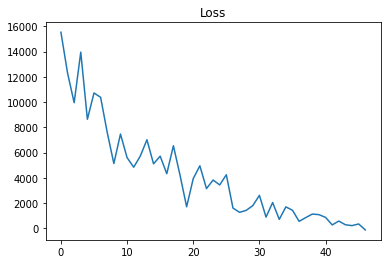

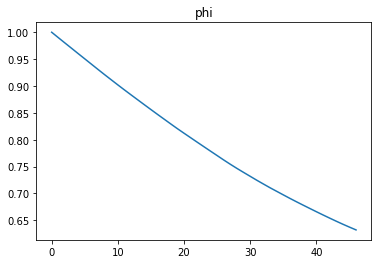

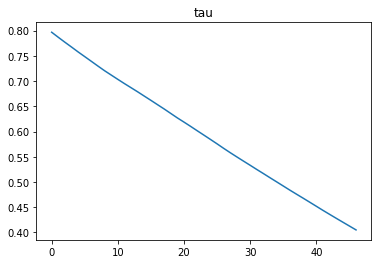

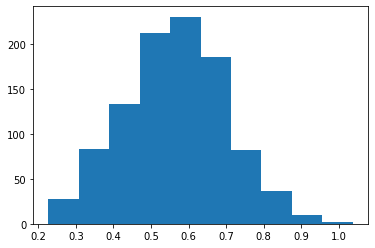

In [ ]:
model = Demo_SGD_MCTrick(1000)
loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

(array([ 27.,  83., 133., 212., 230., 185.,  82.,  36.,  10.,   2.]),
 array([0.22706011, 0.30806348, 0.38906685, 0.4700702 , 0.55107355,
        0.6320769 , 0.7130803 , 0.79408365, 0.875087  , 0.9560904 ,
        1.0370938 ], dtype=float32),
 <a list of 10 Patch objects>)

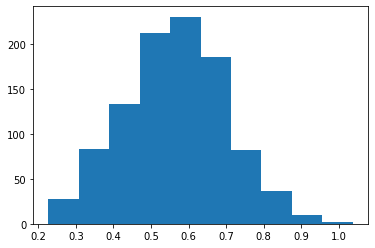

In [ ]:
sb =  model.get_approx().data.numpy()
plt.hist(sb)

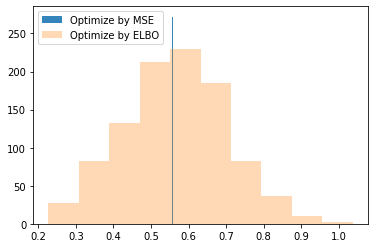

In [ ]:
plt.hist(sa, alpha = 0.9, label='Optimize by MSE')
plt.hist(sb, alpha = 0.3, label='Optimize by ELBO')
plt.legend(loc='upper left')

plt.show()

###  MSE + ELBO: ok

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 16420.302734, RMSE = 0.604610 
+ Param:  {'phi': 1.0, 'tau': 1.3169740438461304}
Epoch 49: 
+ Loss = 3049.908936, RMSE = 0.296828 
+ Param:  {'phi': 0.6287453770637512, 'tau': 0.8844354748725891}
Epoch 99: 
+ Loss = 1142.347900, RMSE = 0.232534 
+ Param:  {'phi': 0.5642579197883606, 'tau': 0.526073157787323}
Epoch 132: 
+ Loss = -54.775490, RMSE = 0.172493 
+ Param:  {'phi': 0.5546949505805969, 'tau': 0.34620803594589233}
----Early stopping----


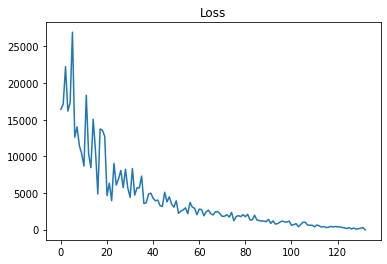

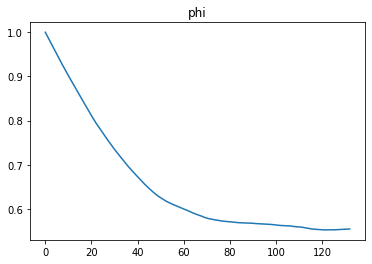

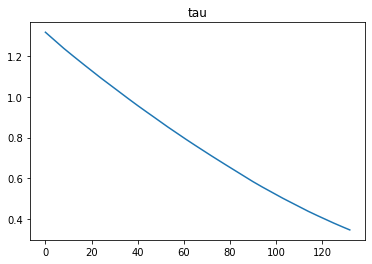

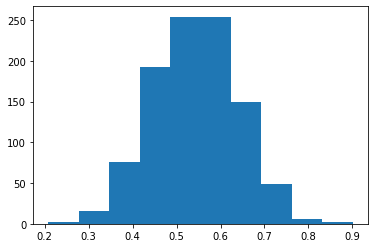

In [ ]:
model = Demo_SGD_MCTrick(1000)
loss_fn = Combining_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

(array([  2.,  16.,  76., 192., 254., 254., 149.,  49.,   6.,   2.]),
 array([0.20848691, 0.27772853, 0.34697014, 0.41621172, 0.48545334,
        0.55469495, 0.62393653, 0.6931782 , 0.76241976, 0.8316614 ,
        0.900903  ], dtype=float32),
 <a list of 10 Patch objects>)

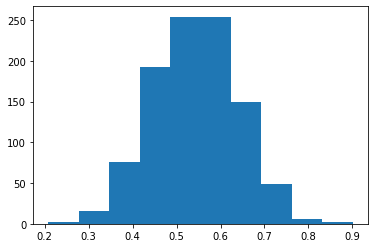

In [ ]:
sc =  model.get_approx().data.numpy()
plt.hist(sc)

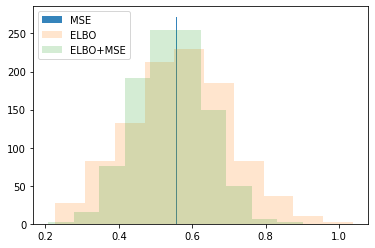

In [ ]:
plt.hist(sa, alpha = 0.9, label='MSE')
plt.hist(sb, alpha = 0.2, label='ELBO')
plt.hist(sc, alpha = 0.2, label='ELBO+MSE')
plt.legend(loc='upper left')

plt.show()

## 3.3 Pytorch models - Inference Network

In [ ]:
class Demo_SGD_InferNet(torch.nn.Module):
    #similar to Demo_SGD_Pyro, but change forward function to fit with Pytorch calling by InferNet
    def __init__(self, his, dim = 1000):
        super(Demo_SGD_InferNet, self).__init__()
        self.his = his
        self.dim = dim
        self.mean_fc = torch.nn.Linear(1, 1)
        self.var_fc = torch.nn.Linear(1, 1)
        self.phi, self.tau = None, None

    def generate(self):
        eps = scale_minmax(torch.randn(self.dim))-0.5
        x_hat = self.phi + self.tau * 2 * eps
        return x_hat

    def forward(self):
        self.phi = torch.mean(self.mean_fc(self.his))
        self.tau = torch.mean(self.var_fc(self.his))
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

(array([ 1.,  4., 11., 11., 11., 26., 12., 14.,  3.,  7.]),
 array([-2.3506098 , -1.9085335 , -1.4664572 , -1.0243809 , -0.58230466,
        -0.14022839,  0.30184788,  0.74392414,  1.1860005 ,  1.6280767 ,
         2.070153  ], dtype=float32),
 <a list of 10 Patch objects>)

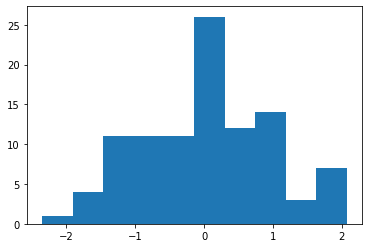

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.hist(torch.randn(100))

#### MSE: ok

Epoch 0: 
+ Loss = 0.257358, RMSE = 0.507305 
+ Param:  {'phi': 0.9750757813453674, 'tau': -0.2699410915374756}
Epoch 49: 
+ Loss = 0.028165, RMSE = 0.167825 
+ Param:  {'phi': 0.497377872467041, 'tau': 0.01967831328511238}
Epoch 99: 
+ Loss = 0.027722, RMSE = 0.166498 
+ Param:  {'phi': 0.5250402092933655, 'tau': 0.004788077902048826}
Epoch 149: 
+ Loss = 0.027735, RMSE = 0.166538 
+ Param:  {'phi': 0.5221923589706421, 'tau': 0.003684088820591569}
Epoch 199: 
+ Loss = 0.027727, RMSE = 0.166514 
+ Param:  {'phi': 0.522197425365448, 'tau': 0.003512633265927434}
Epoch 249: 
+ Loss = 0.027708, RMSE = 0.166458 
+ Param:  {'phi': 0.5221031308174133, 'tau': 0.0033364659175276756}
Epoch 299: 
+ Loss = 0.027715, RMSE = 0.166478 
+ Param:  {'phi': 0.5220668911933899, 'tau': 0.011870586313307285}
Epoch 349: 
+ Loss = 0.027720, RMSE = 0.166493 
+ Param:  {'phi': 0.5220751762390137, 'tau': -0.0016638519009575248}
Epoch 399: 
+ Loss = 0.027716, RMSE = 0.166480 
+ Param:  {'phi': 0.5221100449562073,

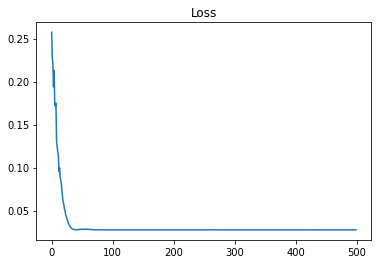

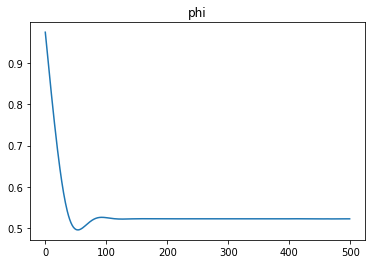

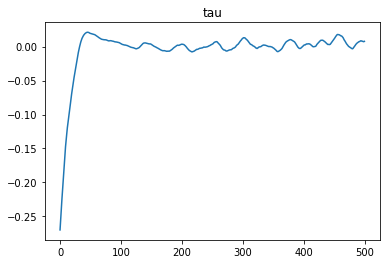

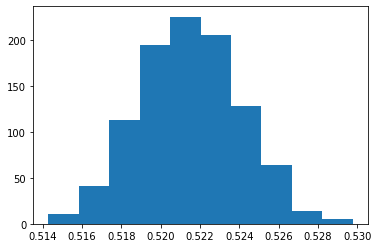

In [ ]:
model = Demo_SGD_InferNet(arr.reshape(1000,1), 1000)
loss_fn = torch.nn.MSELoss(reduction='mean')
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

#### KL

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 1704.895386, RMSE = 0.568464 
+ Param:  {'phi': 0.16586728394031525, 'tau': -1.1572344303131104}
Epoch 40: 
+ Loss = -208.754715, RMSE = 0.424705 
+ Param:  {'phi': 0.08971669524908066, 'tau': -0.5067077279090881}
----Early stopping----


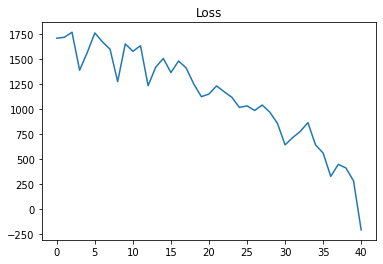

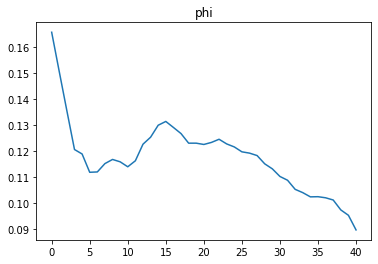

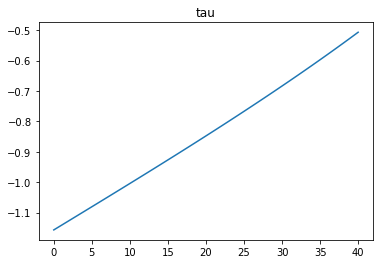

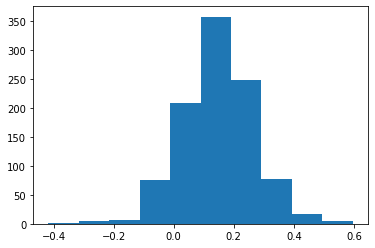

In [ ]:
del model
model = Demo_SGD_InferNet(arr.reshape(1000,1), 1000)
loss_fn = torch.nn.KLDivLoss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training_getlognorm(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 3075.270508, RMSE = 0.382836 
+ Param:  {'phi': 0.4504063129425049, 'tau': 1.005104899406433}
Epoch 46: 
+ Loss = -39.517529, RMSE = 0.198887 
+ Param:  {'phi': 0.519033670425415, 'tau': 0.3878094255924225}
----Early stopping----


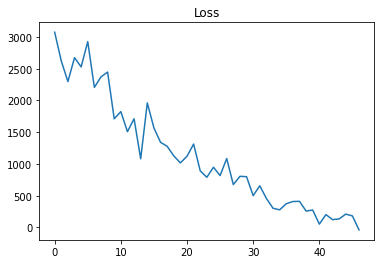

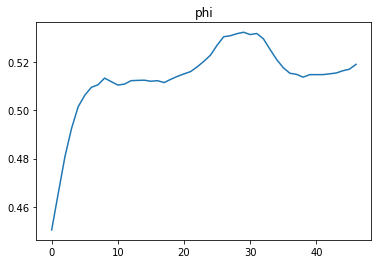

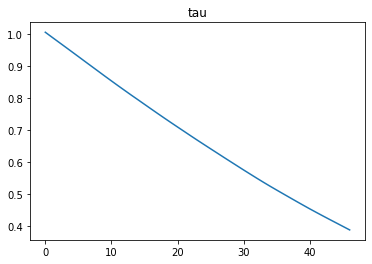

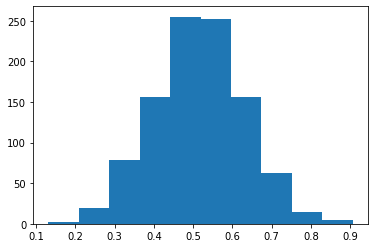

In [ ]:
del model
model = Demo_SGD_InferNet(arr.reshape(1000,1), 1000)
loss_fn = KLDiv_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

#### ELBO: ok

Epoch 0: 
+ Loss = 10269.918945, RMSE = 0.624661 
+ Param:  {'phi': -0.10613461583852768, 'tau': -0.23954668641090393}
Epoch 35: 
+ Loss = -47.299744, RMSE = 0.228694 
+ Param:  {'phi': 0.3632388710975647, 'tau': -0.02724805660545826}
----Early stopping----


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


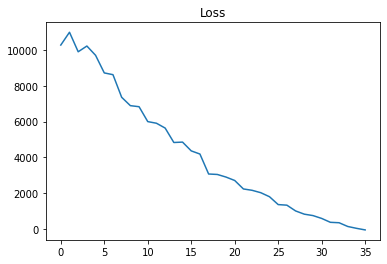

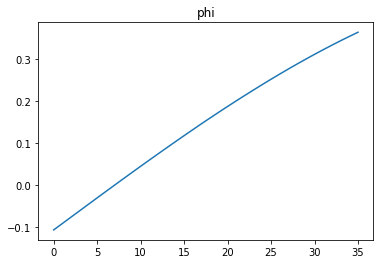

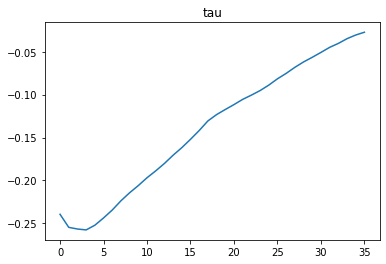

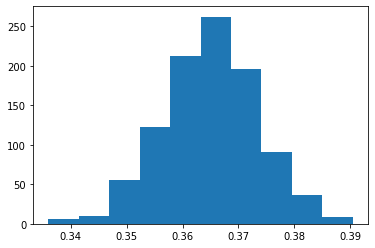

In [ ]:
del model
model = Demo_SGD_InferNet(arr.reshape(1000,1), 1000)
loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

#### MSE + ELBO: ok

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 8944.638672, RMSE = 0.606416 
+ Param:  {'phi': 1.0440508127212524, 'tau': 1.2852356433868408}
Epoch 49: 
+ Loss = 394.996429, RMSE = 0.232813 
+ Param:  {'phi': 0.5182629823684692, 'tau': 0.6253607273101807}
Epoch 71: 
+ Loss = -141.189209, RMSE = 0.201433 
+ Param:  {'phi': 0.5062713623046875, 'tau': 0.3959128260612488}
----Early stopping----


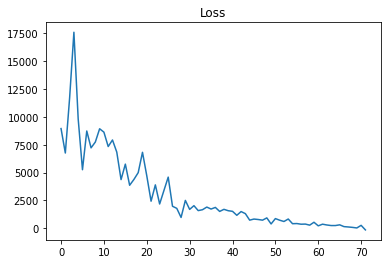

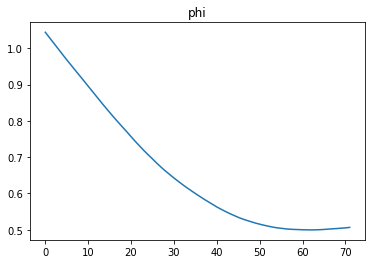

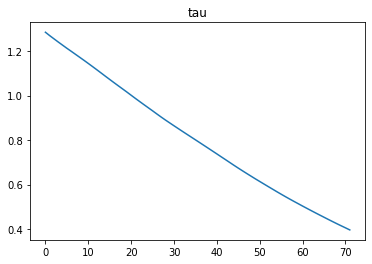

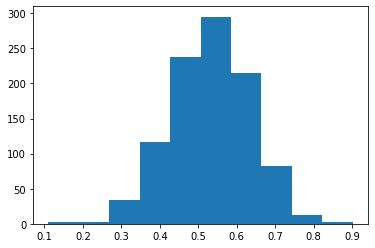

In [ ]:
del model
model = Demo_SGD_InferNet(arr.reshape(1000,1), 1000)
loss_fn = Combining_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

# 4. Optimize models:

Using log_var instead of std:

- std, var must be positive ($>0$), log_var $\in R$
- log_std, log_var is easier to compute in Normal distribution

Impacts:

- Easier to find parameters, less depending on initial values -> smooth loss curve


In [ ]:
def get_mulogvar(x):
    mu, log_var = torch.mean(x), torch.log(torch.var(x))
    return mu, log_var

def log_norm2(x, mu, log_var):
    #similar log_norm2, but generate log_var instead var
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    # return -0.5 * torch.log(2*np.pi*var) -(0.5 * (1/var)* (x-mu)**2)
    return -0.5 * (log_var + np.log(2*np.pi)) -(0.5 * (1/torch.exp(log_var))* (x-mu)**2)

In [ ]:
class Demo_SGD_MCTrick_Optimized(torch.nn.Module):
    #similar Demo_SGD_MCTrick, but generate log_std instead std
    def __init__(self, dim = 1000):
        super(Demo_SGD_MCTrick_Optimized, self).__init__()
        self.dim = dim
        self.phi = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.tau = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.phi.data.fill_(0) #mean, arbitrarily init
        self.tau.data.fill_(-1.0) #log_std, arbitrarily init
        self.x = self.generate()

    def generate(self):
        eps = scale_minmax(torch.randn(self.dim))-0.5
        x_hat = self.phi + torch.exp(self.tau) * 2 * eps
        return x_hat

    def forward(self):
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

In [ ]:
class Demo_SGD_InferNet_Optimized(torch.nn.Module):
    #similar Demo_SGD_InferNet, but generate log_std instead std
    def __init__(self, his, dim = 1000):
        super(Demo_SGD_InferNet_Optimized, self).__init__()
        self.his = his
        self.dim = dim
        self.mean_fc = torch.nn.Linear(1, 1)
        self.var_fc = torch.nn.Linear(1, 1)
        self.phi, self.tau = None, None

    def generate(self):
        eps = scale_minmax(torch.randn(self.dim))-0.5
        x_hat = self.phi + torch.exp(self.tau) * 2 * eps
        return x_hat

    def forward(self):
        self.phi = torch.mean(self.mean_fc(self.his))
        self.tau = torch.mean(self.var_fc(self.his))
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

In [ ]:
# see torch.nn.KLDivLoss
class KLDiv_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(KLDiv_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        return torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)

class ELBO_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(ELBO_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target
        # self.KL_Div = KLDiv_Loss(size_average, reduce, reductio, log_target = True)

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        kl_div = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = log_norm2(target, mu_q, logvar_q)
        if self.reduction == 'mean':
            reconstruct_loss = torch.mean(log_p)
        else:
            reconstruct_loss = torch.sum(log_p)
        elbo = reconstruct_loss - kl_div
        return -elbo

class Combining_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(Combining_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)

        kl_loss = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

        loss = -(reconstruct_loss - kl_loss)
        return loss

## MSE_Loss: ok

Epoch 0: 
+ Loss = 0.353643, RMSE = 0.594679 
+ Param:  {'phi': 0.0, 'tau': -1.0}
Epoch 99: 
+ Loss = 0.022086, RMSE = 0.148615 
+ Param:  {'phi': 0.563951849937439, 'tau': -1.615998387336731}
Epoch 199: 
+ Loss = 0.021528, RMSE = 0.146723 
+ Param:  {'phi': 0.5695987343788147, 'tau': -1.999962568283081}
Epoch 299: 
+ Loss = 0.020692, RMSE = 0.143847 
+ Param:  {'phi': 0.5699517130851746, 'tau': -2.2649741172790527}
Epoch 399: 
+ Loss = 0.020090, RMSE = 0.141738 
+ Param:  {'phi': 0.5713176727294922, 'tau': -2.4587225914001465}
Epoch 499: 
+ Loss = 0.020061, RMSE = 0.141638 
+ Param:  {'phi': 0.5701038241386414, 'tau': -2.612968683242798}
Epoch 599: 
+ Loss = 0.019826, RMSE = 0.140803 
+ Param:  {'phi': 0.570266604423523, 'tau': -2.742180824279785}
Epoch 699: 
+ Loss = 0.019797, RMSE = 0.140702 
+ Param:  {'phi': 0.56898432970047, 'tau': -2.8603038787841797}
Epoch 799: 
+ Loss = 0.019288, RMSE = 0.138882 
+ Param:  {'phi': 0.5685201287269592, 'tau': -2.9612436294555664}
Epoch 899: 
+ L

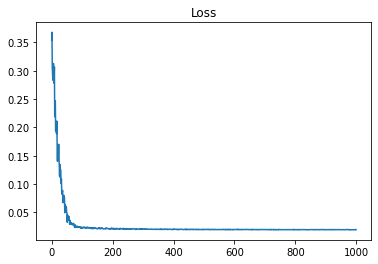

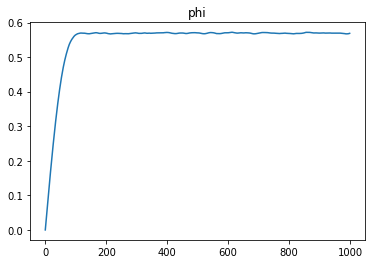

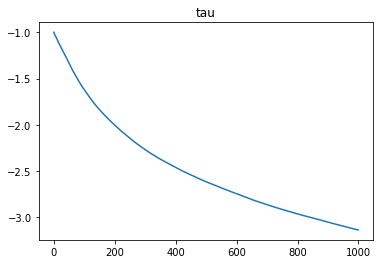

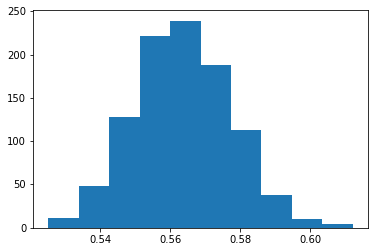

In [ ]:
# del model
model = Demo_SGD_MCTrick_Optimized(1000)
loss_fn = torch.nn.MSELoss(reduction='mean')
loss_track, param_track = sgd_training(model, loss_fn, arr, epochs=1000)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_mse_mc = model.get_approx().data.numpy()

Epoch 0: 
+ Loss = 0.031782, RMSE = 0.178275 
+ Param:  {'phi': 0.5565466284751892, 'tau': -0.9118746519088745}
Epoch 49: 
+ Loss = 0.024172, RMSE = 0.155472 
+ Param:  {'phi': 0.5693473219871521, 'tau': -1.5485498905181885}
Epoch 99: 
+ Loss = 0.021618, RMSE = 0.147030 
+ Param:  {'phi': 0.5641810894012451, 'tau': -1.9155220985412598}
Epoch 149: 
+ Loss = 0.019896, RMSE = 0.141053 
+ Param:  {'phi': 0.5744593739509583, 'tau': -2.1589407920837402}
Epoch 199: 
+ Loss = 0.020161, RMSE = 0.141990 
+ Param:  {'phi': 0.5809741020202637, 'tau': -2.3461835384368896}
Epoch 249: 
+ Loss = 0.019680, RMSE = 0.140285 
+ Param:  {'phi': 0.5679782629013062, 'tau': -2.494837999343872}
Epoch 299: 
+ Loss = 0.019922, RMSE = 0.141146 
+ Param:  {'phi': 0.568740725517273, 'tau': -2.6158289909362793}
Epoch 349: 
+ Loss = 0.019739, RMSE = 0.140497 
+ Param:  {'phi': 0.5694619417190552, 'tau': -2.7207353115081787}
Epoch 399: 
+ Loss = 0.019685, RMSE = 0.140303 
+ Param:  {'phi': 0.5652488470077515, 'tau': -

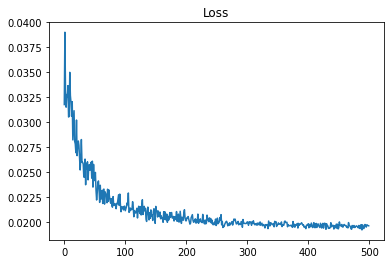

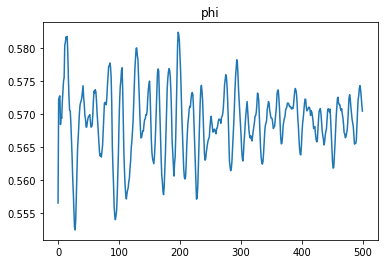

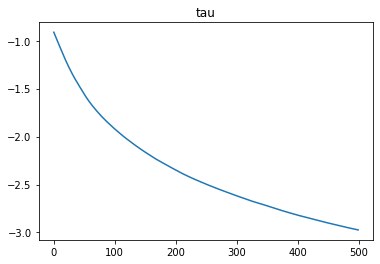

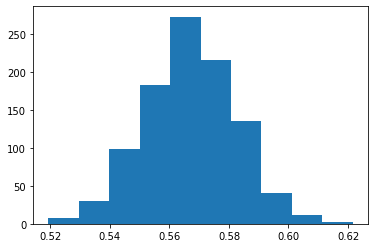

In [ ]:
del model
model = Demo_SGD_InferNet_Optimized(arr.reshape(1000,1), 1000)
loss_fn = torch.nn.MSELoss(reduction='mean')
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_mse_in = model.get_approx().data.numpy()

## KL Loss: ok

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 18398.531250, RMSE = 0.615972 
+ Param:  {'phi': 0.0, 'tau': -1.0}
Epoch 60: 
+ Loss = -12.404983, RMSE = 0.171547 
+ Param:  {'phi': 0.4768093228340149, 'tau': -1.3132435083389282}
----Early stopping----


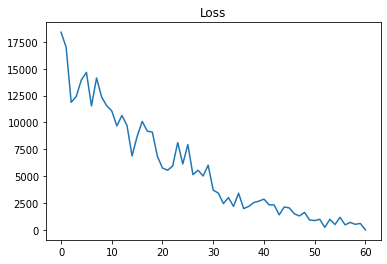

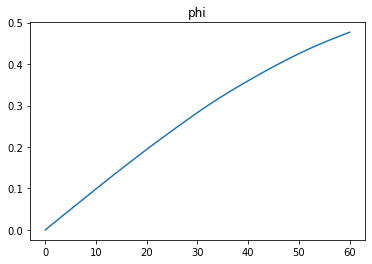

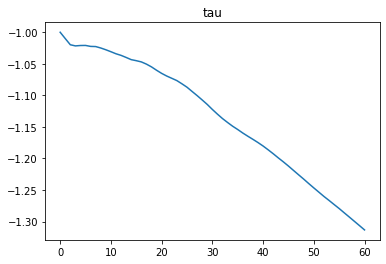

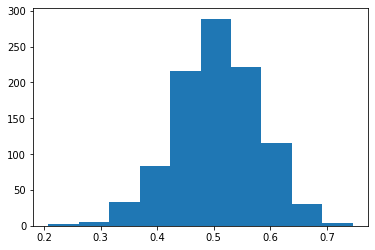

In [ ]:
# del model
model = Demo_SGD_MCTrick_Optimized(1000)
loss_fn = KLDiv_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr, epochs=1000)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_kl_mc = model.get_approx().data.numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 56001.589844, RMSE = 1.030365 
+ Param:  {'phi': 0.7326288223266602, 'tau': 1.1862190961837769}
Epoch 49: 
+ Loss = 11431.494141, RMSE = 0.508799 
+ Param:  {'phi': 0.5853394865989685, 'tau': 0.547633945941925}
Epoch 99: 
+ Loss = 8438.721680, RMSE = 0.423844 
+ Param:  {'phi': 0.5471113324165344, 'tau': 0.186771422624588}
Epoch 149: 
+ Loss = 5367.448730, RMSE = 0.362365 
+ Param:  {'phi': 0.5758379101753235, 'tau': -0.049275971949100494}
Epoch 199: 
+ Loss = 2646.064209, RMSE = 0.282161 
+ Param:  {'phi': 0.5827422142028809, 'tau': -0.23005183041095734}
Epoch 249: 
+ Loss = 2525.905762, RMSE = 0.275772 
+ Param:  {'phi': 0.5883782505989075, 'tau': -0.37439513206481934}
Epoch 299: 
+ Loss = 1966.456543, RMSE = 0.252727 
+ Param:  {'phi': 0.5944867134094238, 'tau': -0.4994443655014038}
Epoch 349: 
+ Loss = 1064.154053, RMSE = 0.220410 
+ Param:  {'phi': 0.5755344033241272, 'tau': -0.609011173248291}
Epoch 399: 
+ Loss = 601.051941, RMSE = 0.200165 
+ Param:  {'phi': 

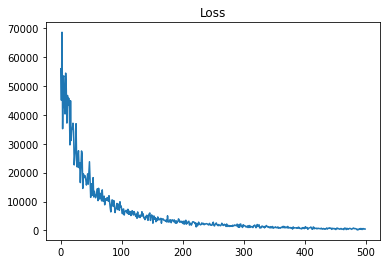

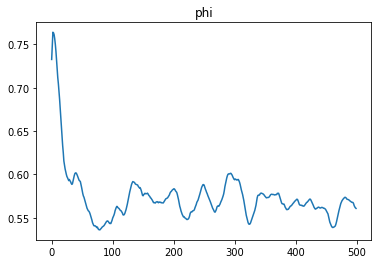

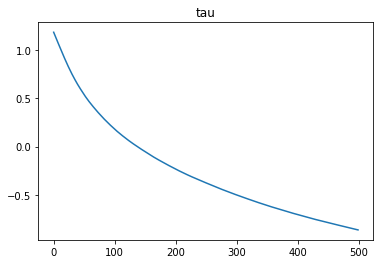

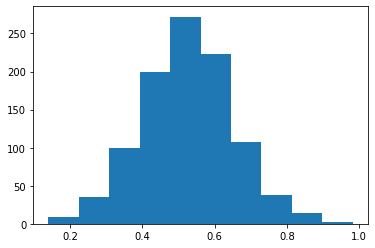

In [ ]:
del model
model = Demo_SGD_InferNet_Optimized(arr.reshape(1000,1), 1000)
loss_fn = KLDiv_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_kl_in = model.get_approx().data.numpy()

## ELBO Loss: ok

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 21218.281250, RMSE = 0.665133 
+ Param:  {'phi': 0.0, 'tau': -1.0}
Epoch 54: 
+ Loss = -351.393921, RMSE = 0.181231 
+ Param:  {'phi': 0.4431249797344208, 'tau': -1.3481807708740234}
----Early stopping----


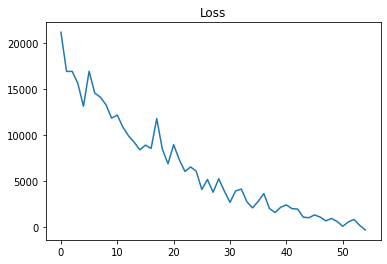

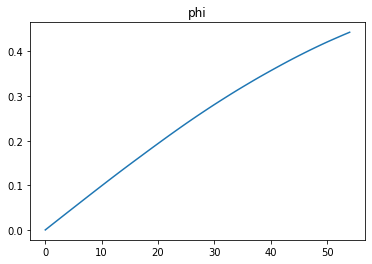

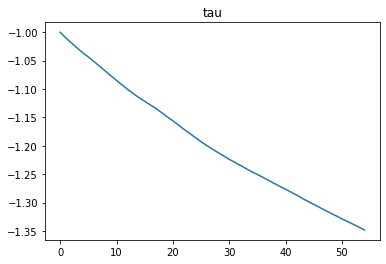

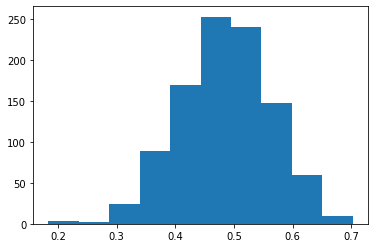

In [ ]:
del model
model = Demo_SGD_MCTrick_Optimized(1000)
loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr, epochs=1000)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_elbo_mc = model.get_approx().data.numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 37171.828125, RMSE = 0.859925 
+ Param:  {'phi': -0.28240838646888733, 'tau': -0.6504193544387817}
Epoch 49: 
+ Loss = 1086.710083, RMSE = 0.246224 
+ Param:  {'phi': 0.364623099565506, 'tau': -1.1200635433197021}
Epoch 59: 
+ Loss = -188.975189, RMSE = 0.187246 
+ Param:  {'phi': 0.4416927397251129, 'tau': -1.1920137405395508}
----Early stopping----


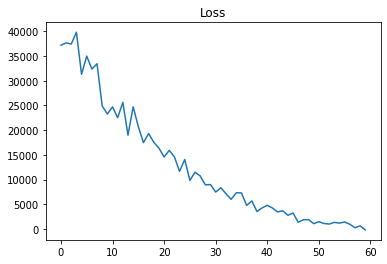

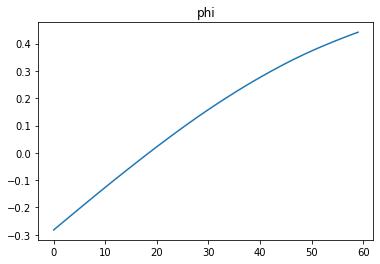

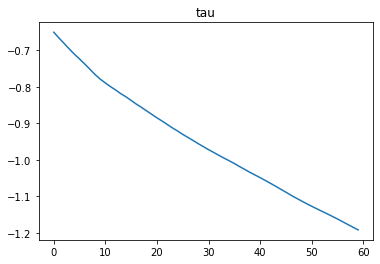

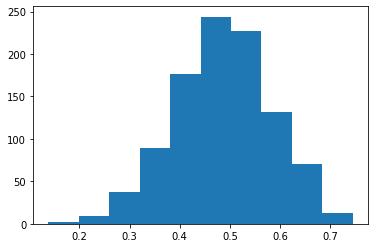

In [ ]:
del model
model = Demo_SGD_InferNet_Optimized(arr.reshape(1000,1), 1000)
loss_fn = ELBO_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_elbo_in = model.get_approx().data.numpy()

## Combine Loss: ok

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 19451.898438, RMSE = 0.636148 
+ Param:  {'phi': 0.0, 'tau': -1.0}
Epoch 61: 
+ Loss = -127.448822, RMSE = 0.163875 
+ Param:  {'phi': 0.4786030054092407, 'tau': -1.3676942586898804}
----Early stopping----


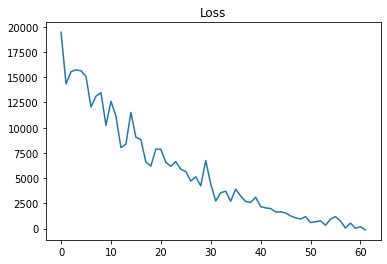

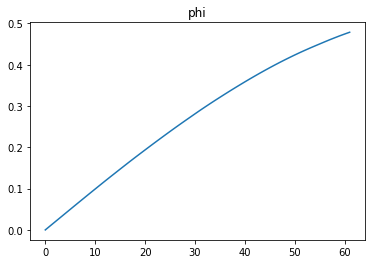

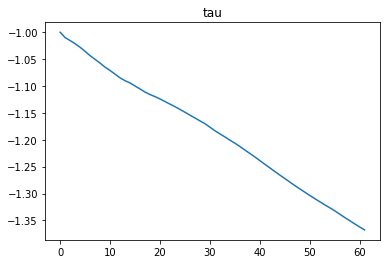

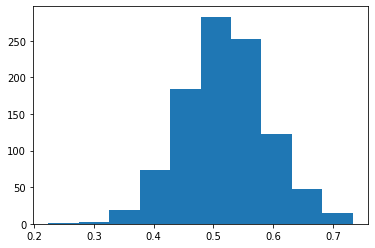

In [ ]:
del model
model = Demo_SGD_MCTrick_Optimized(1000)
loss_fn = Combining_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr, epochs=1000)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_comb_mc = model.get_approx().data.numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: 
+ Loss = 49685.000000, RMSE = 1.000072 
+ Param:  {'phi': -0.35484862327575684, 'tau': 0.032276701182127}
Epoch 49: 
+ Loss = 5186.630371, RMSE = 0.361867 
+ Param:  {'phi': 0.30572280287742615, 'tau': -0.5367952585220337}
Epoch 99: 
+ Loss = 411.353882, RMSE = 0.189522 
+ Param:  {'phi': 0.5558928847312927, 'tau': -0.8839893341064453}
Epoch 136: 
+ Loss = -76.531944, RMSE = 0.168046 
+ Param:  {'phi': 0.5755758285522461, 'tau': -1.0647003650665283}
----Early stopping----


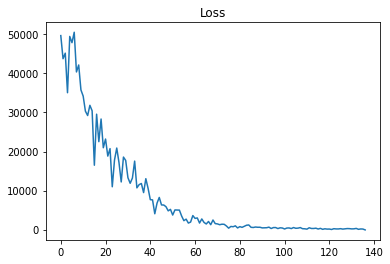

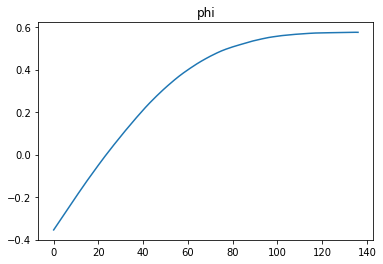

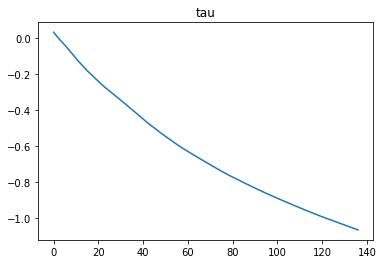

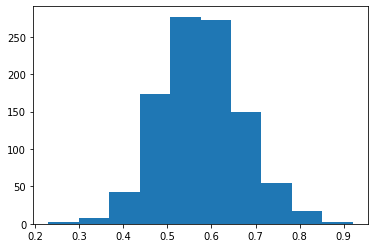

In [ ]:
del model
model = Demo_SGD_InferNet_Optimized(arr.reshape(1000,1), 1000)
loss_fn = Combining_Loss(reduction='sum', size_average=False, log_target= True)
loss_track, param_track = sgd_training(model, loss_fn, arr)
visualize(loss_track, param_track, model.get_approx().data.numpy())

In [ ]:
s_comb_in = model.get_approx().data.numpy()

# Visualize performance

In [ ]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred-target)**2))

### Inference Network

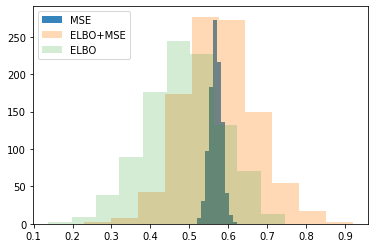

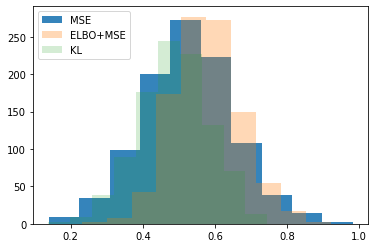

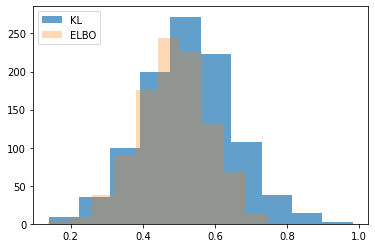

In [ ]:
plt.hist(s_mse_in, alpha = 0.9, label='MSE')
plt.hist(s_comb_in, alpha = 0.3, label='ELBO+MSE')
plt.hist(s_elbo_in, alpha = 0.2, label='ELBO')
plt.legend(loc='upper left')
plt.show()

plt.hist(s_kl_in, alpha = 0.9, label='MSE')
plt.hist(s_comb_in, alpha = 0.3, label='ELBO+MSE')
plt.hist(s_elbo_in, alpha = 0.2, label='KL')
plt.legend(loc='upper left')
plt.show()


plt.hist(s_kl_in, alpha = 0.7, label='KL')
plt.hist(s_elbo_in, alpha = 0.3, label='ELBO')
plt.legend(loc='upper left')
plt.show()

In [ ]:
r_mse_in = rmse(s_mse_in, arr.data.numpy())
r_kl_in = rmse(s_kl_in, arr.data.numpy())
r_elbo_in = rmse(s_elbo_in, arr.data.numpy())
r_comb_in = rmse(s_comb_in, arr.data.numpy())
import pandas as pd
pd.DataFrame({'Loss function':['MSE', 'KL', 'ELBO', 'ELBO+MSE'], 'RMSE': [r_mse_in, r_kl_in, r_elbo_in, r_comb_in]})

,Loss function,RMSE
0,MSE,0.140185
1,KL,0.189413
2,ELBO,0.187246
3,ELBO+MSE,0.168046


### Reparameterized Trick by MCMC

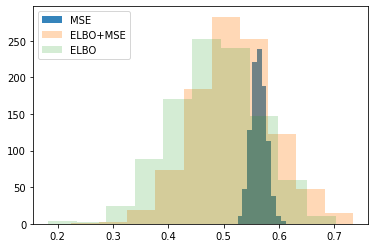

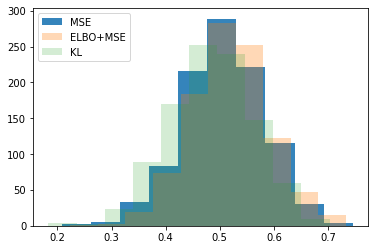

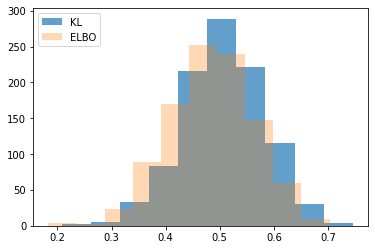

In [ ]:
plt.hist(s_mse_mc, alpha = 0.9, label='MSE')
plt.hist(s_comb_mc, alpha = 0.3, label='ELBO+MSE')
plt.hist(s_elbo_mc, alpha = 0.2, label='ELBO')
plt.legend(loc='upper left')
plt.show()

plt.hist(s_kl_mc, alpha = 0.9, label='MSE')
plt.hist(s_comb_mc, alpha = 0.3, label='ELBO+MSE')
plt.hist(s_elbo_mc, alpha = 0.2, label='KL')
plt.legend(loc='upper left')
plt.show()


plt.hist(s_kl_mc, alpha = 0.7, label='KL')
plt.hist(s_elbo_mc, alpha = 0.3, label='ELBO')
plt.legend(loc='upper left')
plt.show()

In [ ]:
r_mse_mc = rmse(s_mse_mc, arr.data.numpy())
r_kl_mc = rmse(s_kl_mc, arr.data.numpy())
r_elbo_mc = rmse(s_elbo_mc, arr.data.numpy())
r_comb_mc = rmse(s_comb_mc, arr.data.numpy())
import pandas as pd
pd.DataFrame({'Loss function':['MSE', 'KL', 'ELBO', 'ELBO+MSE'], 'RMSE': [r_mse_mc, r_kl_mc, r_elbo_mc, r_comb_mc]})

,Loss function,RMSE
0,MSE,0.139905
1,KL,0.171547
2,ELBO,0.181231
3,ELBO+MSE,0.163875
